In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from arviz import *

In [2]:
df = pd.read_csv("./corona_cases.txt", header=0)
#df.index = pd.to_datetime(df['Date'])
df["Tot"] = np.cumsum(df["Cases"])
df["dCases"] = df["Tot"] - df["Tot"].shift(1)
df["Growth Factor"] = df["dCases"]/df["dCases"].shift(1).where(df["dCases"]!=0)
df["log dCases"] = np.log(df["dCases"].where(df["dCases"] > 0, np.nan))
df

,Date,Cases,Tot,dCases,Growth Factor,log dCases
0,2020-02-01,1,1,NaN,NaN,NaN
1,2020-02-02,1,2,1.0,NaN,0.000000
2,2020-02-03,0,2,0.0,NaN,NaN
3,2020-02-04,0,2,0.0,NaN,NaN
4,2020-02-05,0,2,0.0,NaN,NaN
5,2020-02-06,2,4,2.0,inf,0.693147
6,2020-02-07,0,4,0.0,NaN,NaN
7,2020-02-08,1,5,1.0,inf,0.000000
8,2020-02-09,0,5,0.0,NaN,NaN
9,2020-02-10,4,9,4.0,inf,1.386294


Assuming exponential growth:

$$ \text{Cases}(t) = ae^{r t} (t \ \text{in days}) $$

$$ \log(\text{Cases})(t) = \log(a) + r t $$

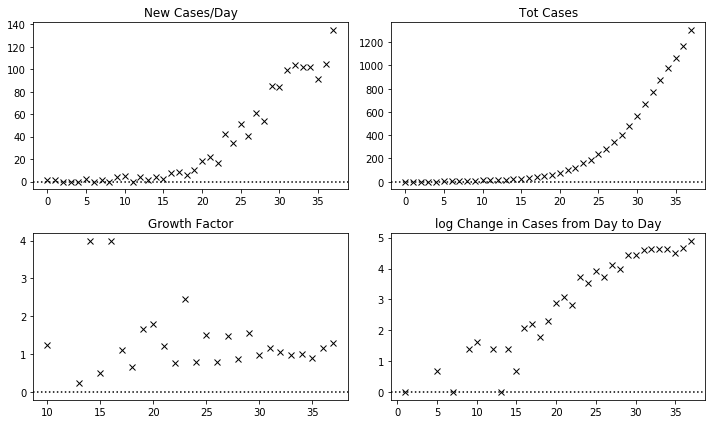

In [3]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(df.index, df["Cases"], c="None", marker="x", mfc="k")
ax[0,0].axhline(0, c="k", ls=":")
ax[0,0].set_title("New Cases/Day")
ax[0,1].plot(df.index, df["Tot"], c="None", marker="x", mfc="k")
ax[0,1].axhline(0, c="k", ls=":")
ax[0,1].set_title("Tot Cases")
ax[1,0].plot(df.index, df["Growth Factor"], c="None", marker="x", mfc="k")
ax[1,0].axhline(0, c="k", ls=":")
ax[1,0].set_title("Growth Factor")
ax[1,1].plot(df.index, df["log dCases"], c="None", marker="x", mfc="k")
ax[1,1].axhline(0, c="k", ls=":")
ax[1,1].set_title("log Change in Cases from Day to Day")
plt.tight_layout()

Our model for the (log) growth in the number of cases per day is going to be:

$$ \hat{y}(t) \sim \mathscr{N}(\mu, \sigma) $$

$$ \sigma \sim \mathscr{N}(0, 1.0) $$

$$ a \sim \mathscr{N}(0, 1.0) $$

$$ r \sim \text{Uniform}(0, 2.0) $$

$$ \mu = a + r * t $$

In [4]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1.0)
    r = pm.Uniform('r', lower=0.0, upper=2.0)
    
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    mu = pm.Deterministic('mu', a + r * df.index)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=df["log dCases"])
    
    trace = pm.sample(1000, tune=1000)

/Users/davidwych/miniconda3/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in y_hat contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_hat_missing, sigma, r, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 512.92draws/s]


/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e8647d0>,
      dtype=object)

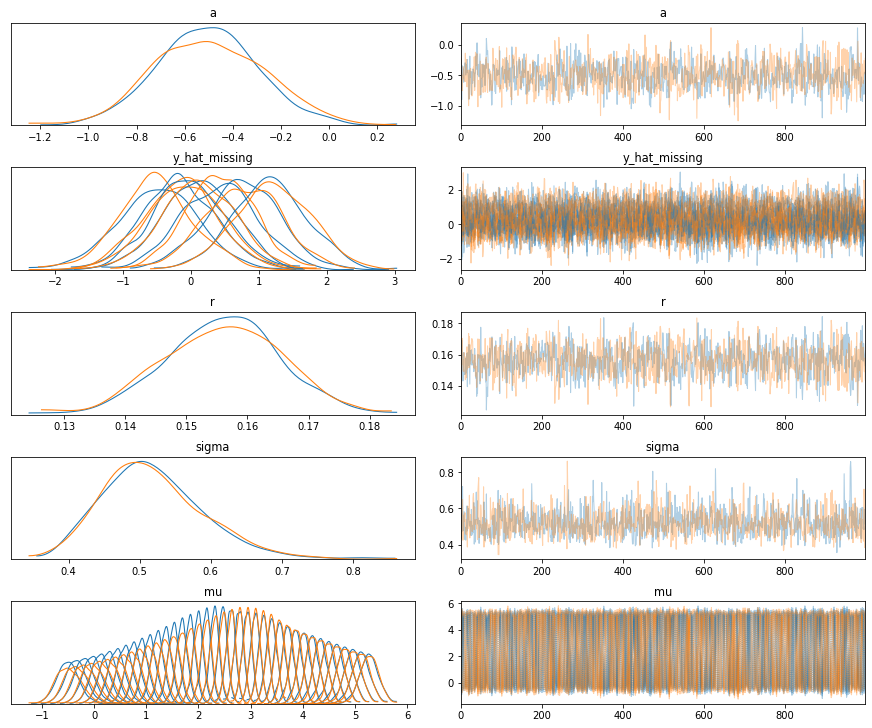

In [5]:
pm.traceplot(trace)

Estimated Doubling Time (days): 4.45


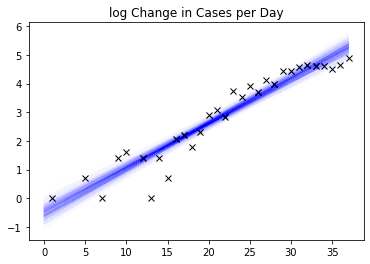

In [6]:
plt.plot(df.index, df["log dCases"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    growth_fac[i] = trace['r'][idx]
    plt.plot(df.index, trace['a'][idx] + trace['r'][idx]*df.index, c="Blue", alpha=0.005)

plt.title("log Change in Cases per Day")
doub_time = np.log(2)/np.mean(growth_fac)
#std_doub_time = np.log(2)/np.std(growth_fac)
print("Estimated Doubling Time (days): {:.2f}".format(doub_time))

Cases by end of next month: 1243904


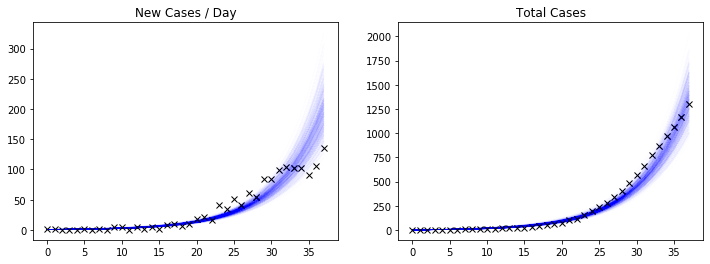

In [7]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(df.index, df["Cases"], c="None", marker="x", mec="k")
ax[1].plot(df.index, df["Tot"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
ampl = np.zeros(1000)
endpoints = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    ampl[idx] = np.exp(trace['a'][idx])
    _cases = ampl[idx]*np.exp(trace['r'][idx]*df.index)
    _accum = np.cumsum(_cases)
    _cases_ext = ampl[idx]*np.exp(trace['r'][idx]*np.arange(len(df.index)+13+30))
    _accum_ext = np.cumsum(_cases_ext)
    endpoints[i] = _accum_ext[-1]
    
    ax[0].plot(df.index, _cases, c="Blue", alpha=0.005)
    ax[0].set_title("New Cases / Day")
    ax[1].plot(df.index, _accum, c="Blue", alpha=0.005)
    ax[1].set_title("Total Cases")

avg_cases = np.mean(endpoints)

print("Cases by end of next month: {:.0f}".format(avg_cases))

Text(0.5, 1.0, 'Cases by the End of Next Month')

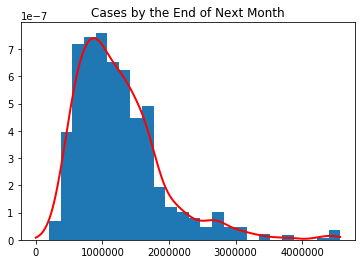

In [8]:
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
n, bins, patches = ax.hist(endpoints, bins=25, density=True)
density = gaussian_kde(endpoints)
xs = np.linspace(0,bins[-1],200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), c="Red", lw=2.0)
ax.set_title("Cases by the End of Next Month")
#ax.set_xticks(np.linspace(0,2e6, 8))
#ax.set_xticklabels([str[el] for el in np.linspace(0,2e6, 8)], rotation=30)

# From COVID TRACKER

In [14]:
data = pd.read_csv("us-daily.csv")

In [15]:
data

,date,states,positive,negative,posNeg,pending,death,total
0,20200304,14,118,748,866,103,NaN,969
1,20200305,24,176,971,1147,197,NaN,1344
2,20200306,36,223,1617,1840,458,NaN,2298
3,20200307,51,341,1863,2204,602,NaN,2806
4,20200308,51,417,2437,2854,347,NaN,3201
5,20200309,51,584,3500,4084,313,NaN,4397
6,20200310,51,778,3807,4585,469,NaN,5054
7,20200311,51,1053,5978,7031,563,27.0,7617
8,20200312,51,1315,7950,9265,673,36.0,9967
9,20200313,51,1922,13513,15435,1130,39.0,16565


In [25]:
data["log dpositive"] = np.log(data["positive"] - data["positive"].shift(1))

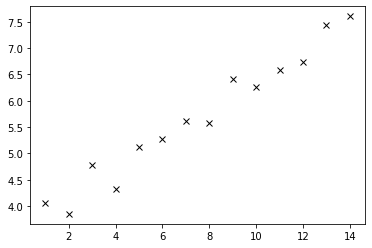

In [27]:
plt.plot(data.index, data["log dpositive"], c="None", mfc="k", marker="x")

In [29]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1.0)
    r = pm.Uniform('r', lower=0.0, upper=2.0)
    
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    mu = pm.Deterministic('mu', a + r * data.index)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=data["log dpositive"])
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_hat_missing, sigma, r, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 617.68draws/s]
The acceptance probability does not match the target. It is 0.8813304658501174, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805605654885629, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2bad95d0>,
      dtype=object)

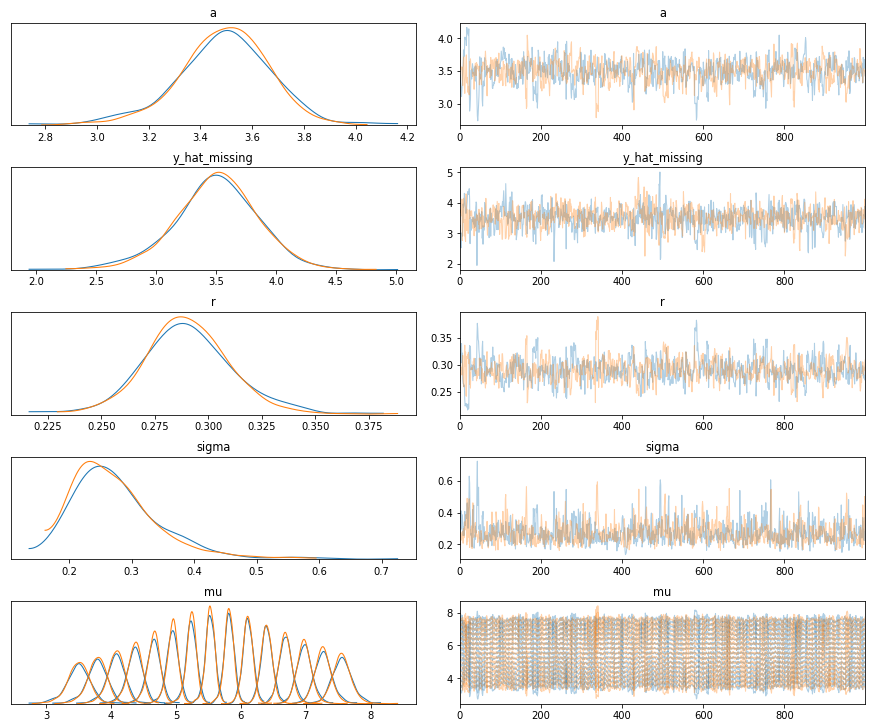

In [30]:
pm.traceplot(trace)

Estimated Doubling Time (days): 2.38


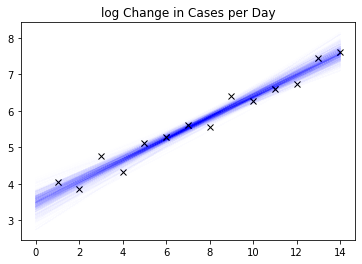

In [32]:
plt.plot(data.index, data["log dpositive"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    growth_fac[i] = trace['r'][idx]
    plt.plot(data.index, trace['a'][idx] + trace['r'][idx]*data.index, c="Blue", alpha=0.005)

plt.title("log Change in Cases per Day")
doub_time = np.log(2)/np.mean(growth_fac)
#std_doub_time = np.log(2)/np.std(growth_fac)
print("Estimated Doubling Time (days): {:.2f}".format(doub_time))

Cases by end of this month: 199487


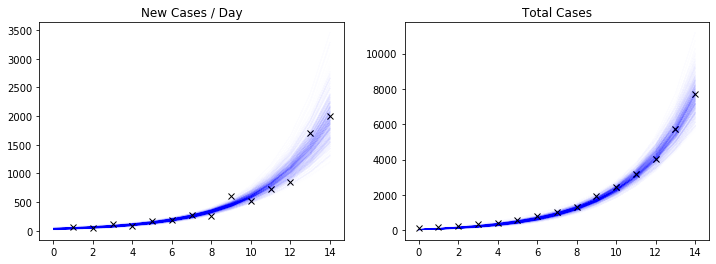

In [35]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(data.index, data["dpositive"], c="None", marker="x", mec="k")
ax[1].plot(data.index, data["positive"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
ampl = np.zeros(1000)
endpoints = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    ampl[idx] = np.exp(trace['a'][idx])
    _cases = ampl[idx]*np.exp(trace['r'][idx]*data.index)
    _accum = np.cumsum(_cases)
    _cases_ext = ampl[idx]*np.exp(trace['r'][idx]*np.arange(len(data.index)+11))
    _accum_ext = np.cumsum(_cases_ext)
    endpoints[i] = _accum_ext[-1]
    
    ax[0].plot(data.index, _cases, c="Blue", alpha=0.005)
    ax[0].set_title("New Cases / Day")
    ax[1].plot(data.index, _accum, c="Blue", alpha=0.005)
    ax[1].set_title("Total Cases")

avg_cases = np.mean(endpoints)

print("Cases by end of this month: {:.0f}".format(avg_cases))

Text(0.5, 1.0, 'Cases by the End of Next Month')

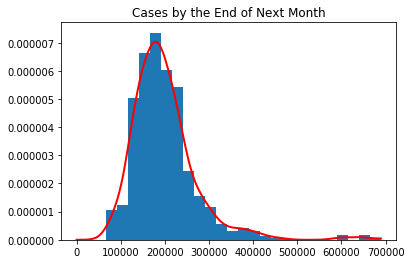

In [36]:
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
n, bins, patches = ax.hist(endpoints, bins=25, density=True)
density = gaussian_kde(endpoints)
xs = np.linspace(0,bins[-1],200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), c="Red", lw=2.0)
ax.set_title("Cases by the End of Next Month")
#ax.set_xticks(np.linspace(0,2e6, 8))
#ax.set_xticklabels([str[el] for el in np.linspace(0,2e6, 8)], rotation=30)